In [13]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv("/content/SMSSmishCollection.txt", sep="\t", names=["label", "text"])
df['label'] = df['label'].map({'ham': 0, 'smish': 1})
df.head()


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
def clean_text(text):
    text = text.lower()                                 # lowercasing
    text = re.sub(r"http\S+|www\S+", "", text)          # remove URLs
    text = re.sub(r"\d+", "", text)                     # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  # punctuation
    words = text.split()
    words = [w for w in words if w not in stop_words]   # remove stopwords
    return " ".join(words)

df["cleaned_text"] = df["text"].apply(clean_text)

In [6]:
X = df["cleaned_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ("lr", LogisticRegression(max_iter=200, class_weight='balanced'))
])


In [8]:
param_grid = {
    "lr__C": [0.1, 1, 3, 5],
    "lr__solver": ["liblinear", "lbfgs"]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'lr__C': 5, 'lr__solver': 'lbfgs'}


In [9]:

y_pred = best_model.predict(X_test)

print("\n📌 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



📌 Accuracy: 0.97847533632287

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.92      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115


📌 Confusion Matrix:
 [[954  12]
 [ 12 137]]


In [10]:
joblib.dump(best_model, "smishing_model.pkl")
print("\n🚀 Model saved as smishing_model.pkl")



🚀 Model saved as smishing_model.pkl


In [12]:
def predict_sms(text):
    cleaned = clean_text(text)
    pred = best_model.predict([cleaned])[0]
    return "smish" if pred == 1 else "ham"

# Example
print("\nTest Prediction:", predict_sms("Congratulations! Click this link to claim your prize now."))



Test Prediction: smish


/tmp/ipython-input-1035104468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"].map({0:"ham", 1:"smish"}), palette="viridis")


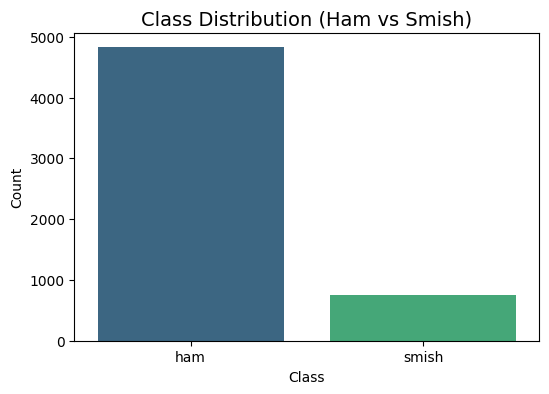

In [14]:
# 1️⃣ Class Distribution
# -------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df["label"].map({0:"ham", 1:"smish"}), palette="viridis")
plt.title("Class Distribution (Ham vs Smish)", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

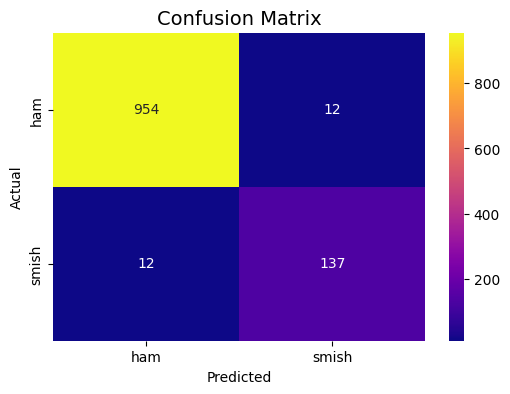

In [15]:
# 2️⃣ Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma",
            xticklabels=["ham", "smish"],
            yticklabels=["ham", "smish"])
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

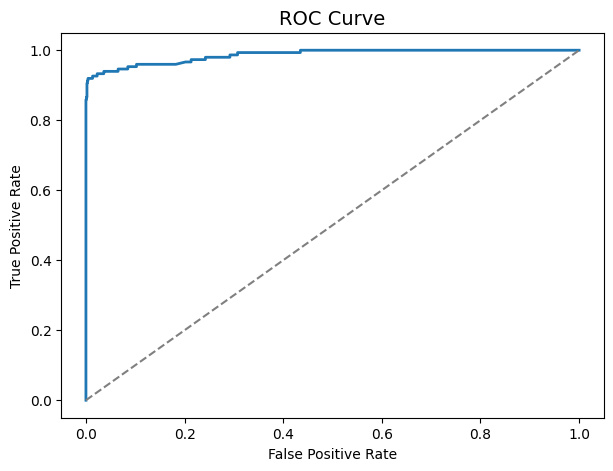

AUC Score: 0.9863930690455347


In [19]:
# 3️⃣ ROC Curve
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_prob))

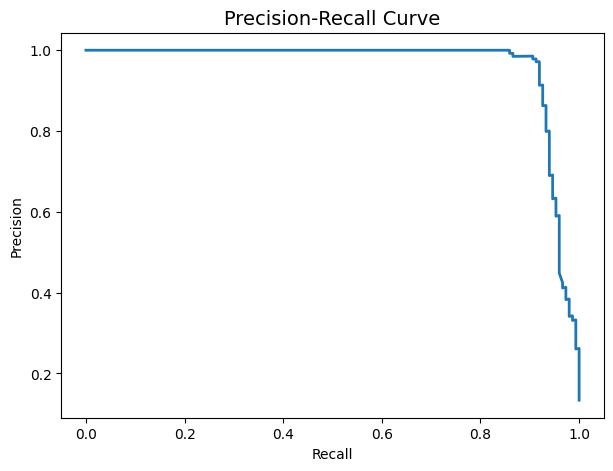

In [17]:
# 4️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, linewidth=2)
plt.title("Precision-Recall Curve", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()